# Top Rated TV Episodes

This is a mini personal project which I spent no more than 2 hours and frankly did it because I couldn't sleep last night due to insomnia. It is entirely autonomous, just input an IMDB id and it works for you.

It essentially scrapes the given TV show on IMDb and returns either the best or the worst episodes depending on the parameter (default is top). I also did some plotting to see how the TV show changed in time. (Game of Thrones was a good example, looking at you writers!)

After I completed the project, I realised IMDb offers a top-rated episodes page. However, it wouldn't be useful for me anyway because I wanted to see the change in time and that page doesn't give me the season/episode details apart from the episode name.

I also needed to waste some time pretty badly.

In [16]:
%matplotlib inline

In [17]:
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import re
from operator import itemgetter

In [18]:
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers = {'User-Agent': user_agent}

In [19]:
# Some IMDb ids
game_of_thrones = 'tt0944947'
chuck = 'tt0934814'
peep_show = 'tt0387764'
winter_sleep = 'tt2758880'

In [20]:
class TVShow:

    def __init__(self, imdb_id, best):
        '''
        Initializes the class, best is True by default; meaning it returns the top episodes.
        Add Fale parameter to the main function to get bottom ones.
        '''
        self.imdb_id = imdb_id
        self.best = best

    def clean_tags(self, raw_html):
        '''
        Cleans out the html code and returns the data inside the tags
        '''
        cleanr = re.compile('<.*?>')
        return re.sub(cleanr, '', str(raw_html))

    def check_seasons(self):
        '''
        Scrapes and returns the amount of seasons of the TV Show for iteration
        '''
        imdb_link = f'https://www.imdb.com/title/{self.imdb_id}/episodes?season='
        # Construct the BeautifulSoup request
        url = Request(f'{imdb_link}1', None, headers)
        html = urlopen(url)
        soup = BeautifulSoup(html.read(), 'html.parser')
        # Find all the seasons and put it in a list
        seasons = soup.find('select', attrs={'id': 'bySeason'})
        season_list = []
        for season in seasons.findAll('option'):
            season_number = int(self.clean_tags(season))
            season_list.append(season_number)

        return season_list

    def get_soup(self, season):
        '''
        Gets the beautiful soup compatible html data
        '''
        imdb_link = f'https://www.imdb.com/title/{self.imdb_id}/episodes?season='

        url = Request(f'{imdb_link}{season}', None, headers)
        html = urlopen(url)
        soup = BeautifulSoup(html.read(), 'html.parser')

        return soup

    def scrape_season(self, soup):
        '''
        Scrapes the individual episodes of the season requested
        '''
        episode_list = []

        for episode in soup.findAll('div', attrs={'class': 'list_item'}):
            # Episode name
            episode_name = episode.find('a', attrs={'itemprop': 'name'})
            name = self.clean_tags(episode_name)
            # Episode number (season, episode)
            episode_number = episode.find(
                'div', attrs={'class': 'hover-over-image'}).find('div')
            number = self.clean_tags(episode_number)
            # Episode rating
            episode_rating = episode.find(
                'span', attrs={'class': 'ipl-rating-star__rating'})
            rating = float(self.clean_tags(episode_rating))
            # Bring all values into a dictionary and push into a list
            episode_info = {
                "name": name,
                "number": number,
                "rating": rating
            }

            episode_list.append(episode_info)

        return episode_list

    def get_best_episodes(self, data):
        '''
        Gets the best episodes of all data
        '''
        episode_list = []

        for season in data:
            for episode in data[season]:
                episode_list.append(episode)

        if self.best:
            sorted_data = sorted(
                episode_list, key=itemgetter('rating'), reverse=True)
        else:
            sorted_data = sorted(
                episode_list, key=itemgetter('rating'))

        # Returns the top 10 episodes
        return sorted_data[:10]

    def plot_values(self, data):
        '''
        Plots the values of given data
        '''
        axis = []
        numbers = []
        num = 1
        for season in data:
            for i in data[season]:
                axis.append(float(i['rating']))
                numbers.append(num)
                num+=1

        plt.figure(figsize=(10, 5))

        plt.plot(numbers, axis)
        plt.suptitle('TV Show Analysis')
        axes = plt.gca()
        axes.set_ylim([0, 10])
        plt.xlabel('Episodes')
        plt.ylabel('IMDb Score')
        plt.show()


In [21]:
def main(imdb_id, best=True):
    
    tv_show = TVShow(imdb_id, best)

    full_data = {}

    # Get all the season data, also validate if the item is tv show
    try:
        seasons = tv_show.check_seasons()
    except HTTPError as e:
        print('This is probably not a TV Show!')
        return False
    except Exception as e:
        print('Something is not working. Check the exception value below')
        print(e.__class__.__name__)
        return False

    for season in seasons:
        soup = tv_show.get_soup(season)
        full_data[f'Season {season}'] = tv_show.scrape_season(soup)

    best_episodes = tv_show.get_best_episodes(full_data)

    i = 1
    top_list = []
    for episode in best_episodes:
        top_list.append(
            f"{i}. Episode: {episode['number']}, {episode['name']}: {episode['rating']}")
        i += 1
    
    if best:
        tv_show.plot_values(full_data)
    return top_list


# Some examples

## Chuck

**Chuck is, overall, a terrific show. However, the last season is a bit downer to be perfectly honest, but somehow they put a smile on your face when it comes to the finale. It can be easily seen from the graph below.**

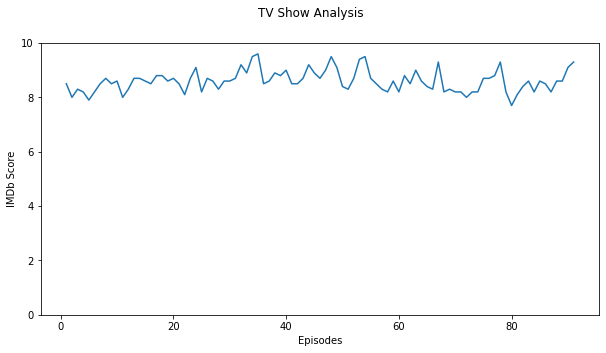

1. Episode: S2, Ep22, Chuck Versus the Ring: 9.6
2. Episode: S2, Ep21, Chuck Versus the Colonel: 9.5
3. Episode: S3, Ep13, Chuck Versus the Other Guy: 9.5
4. Episode: S3, Ep19, Chuck Versus the Ring: Part II: 9.5
5. Episode: S3, Ep18, Chuck Versus the Subway: 9.4
6. Episode: S4, Ep13, Chuck Versus the Push Mix: 9.3
7. Episode: S4, Ep24, Chuck Versus the Cliffhanger: 9.3
8. Episode: S5, Ep13, Chuck Versus the Goodbye: 9.3
9. Episode: S2, Ep19, Chuck Versus the Dream Job: 9.2
10. Episode: S3, Ep9, Chuck Versus the Beard: 9.2


In [22]:
data = main(chuck)
if data:
    for i in data:
        print(i)
    

## Game of Thrones

**Game of Thrones was a worldwide success but ended poorly. I wanted to see the graph and the best episodes.**

### Best Episodes

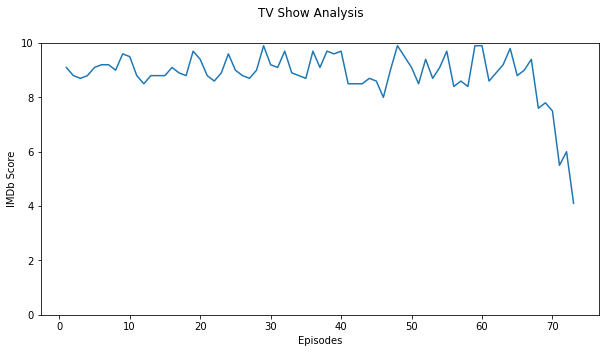

1. Episode: S3, Ep9, The Rains of Castamere: 9.9
2. Episode: S5, Ep8, Hardhome: 9.9
3. Episode: S6, Ep9, Battle of the Bastards: 9.9
4. Episode: S6, Ep10, The Winds of Winter: 9.9
5. Episode: S7, Ep4, The Spoils of War: 9.8
6. Episode: S2, Ep9, Blackwater: 9.7
7. Episode: S4, Ep2, The Lion and the Rose: 9.7
8. Episode: S4, Ep6, The Laws of Gods and Men: 9.7
9. Episode: S4, Ep8, The Mountain and the Viper: 9.7
10. Episode: S4, Ep10, The Children: 9.7


In [23]:
data = main(game_of_thrones)
if data:
    for i in data:
        print(i)

### Worst Episodes

**To check the worst episodes, a False argument can be added to the main function.**

Funny to see that the top 6 is entirely the last season, though I liked the Long Night episode a lot. Apart from the ending of course.

In [24]:
worst_gameoftrones = main(game_of_thrones, False)
if worst_gameoftrones:
    for i in worst_gameoftrones:
        print(i)

1. Episode: S8, Ep6, The Iron Throne: 4.1
2. Episode: S8, Ep4, The Last of the Starks: 5.5
3. Episode: S8, Ep5, The Bells: 6.0
4. Episode: S8, Ep3, The Long Night: 7.5
5. Episode: S8, Ep1, Winterfell: 7.6
6. Episode: S8, Ep2, A Knight of the Seven Kingdoms: 7.8
7. Episode: S5, Ep6, Unbowed, Unbent, Unbroken: 8.0
8. Episode: S6, Ep6, Blood of My Blood: 8.4
9. Episode: S6, Ep8, No One: 8.4
10. Episode: S2, Ep2, The Night Lands: 8.5


## Movie Example

**If it's a movie, it simply returns false.**

In [25]:
data = main(winter_sleep)
if data:
    for i in data:
        print(i)

This is probably not a TV Show!


# Some more examples (for fun)

In [26]:
bojack_horseman = 'tt3398228'
friends = 'tt0108778'
himym = 'tt0460649'
breaking_bad = 'tt0903747'

**Bojack Horseman was really unexpected for me. I am adding a review quote from IMDb that I quite agree with the person.**

```
Unexpected Depth *9/10

At a glance, this show looks like your run of the mill wacky, raunchy adult cartoon comedy. And yes, it has plenty of that with the titular character's rude and obscene behavior, and a saturated slew of animal puns. There are wacky characters and absurd plots to be sure, but all of that eventually takes a backseat to the fact that Bojack Horseman is, at heart, a nuanced and overtly depressing show about pain and self-loathing.

As depressing and serious as the shows ultimate arc really is, the absurdist icing that comes from immersion in this world where anthropomorphic animals are taken for granted helps make this bitter pill an enjoyable meal. 

```

**The graph below is directly proportional to the review. The show basically goes deep in each season.**

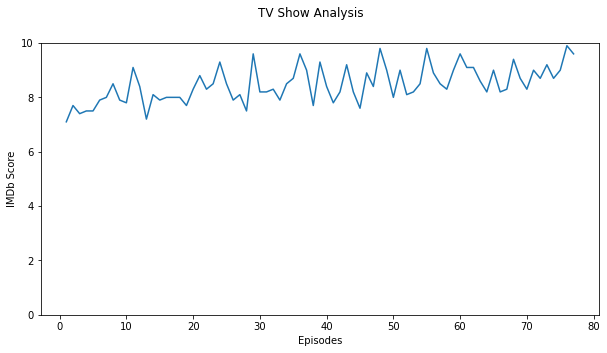

1. Episode: S6, Ep15, The View from Halfway Down: 9.9
2. Episode: S4, Ep11, Time's Arrow: 9.8
3. Episode: S5, Ep6, Free Churro: 9.8
4. Episode: S3, Ep4, Fish Out of Water: 9.6
5. Episode: S3, Ep11, That's Too Much, Man!: 9.6
6. Episode: S5, Ep11, The Showstopper: 9.6
7. Episode: S6, Ep16, Nice While It Lasted: 9.6
8. Episode: S6, Ep7, The Face of Depression: 9.4
9. Episode: S2, Ep11, Escape from L.A.: 9.3
10. Episode: S4, Ep2, The Old Sugarman Place: 9.3


In [27]:
data = main(bojack_horseman)
if data:
    for i in data:
        print(i)

## Breaking Bad

**What a show, right? It just got better and better, check the spike at the end seasons.**

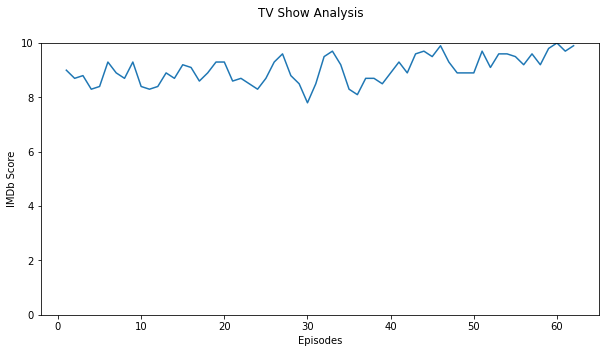

1. Episode: S5, Ep14, Ozymandias: 10.0
2. Episode: S4, Ep13, Face Off: 9.9
3. Episode: S5, Ep16, Felina: 9.9
4. Episode: S5, Ep13, To'hajiilee: 9.8
5. Episode: S3, Ep13, Full Measure: 9.7
6. Episode: S4, Ep11, Crawl Space: 9.7
7. Episode: S5, Ep5, Dead Freight: 9.7
8. Episode: S5, Ep15, Granite State: 9.7
9. Episode: S3, Ep7, One Minute: 9.6
10. Episode: S4, Ep10, Salud: 9.6


In [28]:
data = main(breaking_bad)
if data:
    for i in data:
        print(i)

## Friends

**I think Friends is the first sitcom I have ever watched. It had up and downs, especially the last seasons were not really alright but ended up satisfying the viewers.**

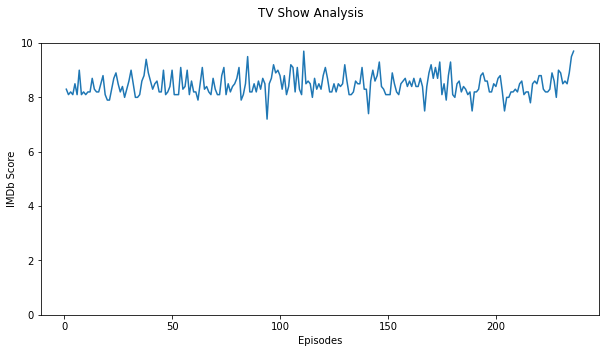

1. Episode: S5, Ep14, The One Where Everybody Finds Out: 9.7
2. Episode: S10, Ep18, The Last One: 9.7
3. Episode: S4, Ep12, The One with the Embryos: 9.5
4. Episode: S10, Ep17, The Last One: 9.5
5. Episode: S2, Ep14, The One with the Prom Video: 9.4
6. Episode: S6, Ep25, The One with the Proposal: 9.3
7. Episode: S8, Ep4, The One with the Videotape: 9.3
8. Episode: S8, Ep9, The One with the Rumor: 9.3
9. Episode: S4, Ep24, The One with Ross's Wedding: Part 2: 9.2
10. Episode: S5, Ep8, The One with All the Thanksgivings: 9.2


In [29]:
data = main(friends)
if data:
    for i in data:
        print(i)

## How I Met Your Mother

**I am not a fan of HIMYM; in fact, I am only putting this because it got compared with Friends a lot back in the old (&gold) days. The show definitely has up and downs; it can also be seen from the graph below. It ages poorly in time, like a milk, but has some outstanding episodes in each season. Overall, there is a significant drop in quality, and in the end, it finished poorly.**

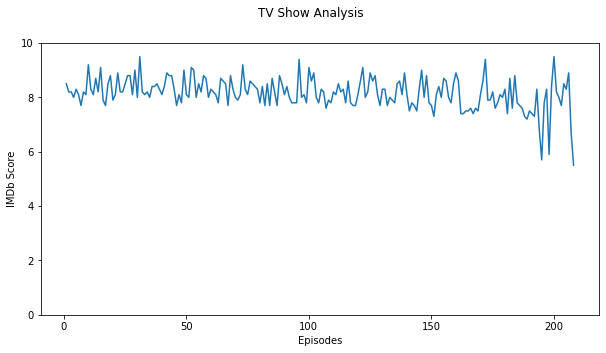

1. Episode: S2, Ep9, Slap Bet: 9.5
2. Episode: S9, Ep16, How Your Mother Met Me: 9.5
3. Episode: S5, Ep8, The Playbook: 9.4
4. Episode: S8, Ep12, The Final Page: Part Two: 9.4
5. Episode: S1, Ep10, The Pineapple Incident: 9.2
6. Episode: S4, Ep9, The Naked Man: 9.2
7. Episode: S1, Ep15, Game Night: 9.1
8. Episode: S3, Ep8, Spoiler Alert: 9.1
9. Episode: S5, Ep12, Girls vs. Suits: 9.1
10. Episode: S6, Ep10, Blitzgiving: 9.1


In [30]:
data = main(himym)
if data:
    for i in data:
        print(i)